In [5]:
#**** Sentiment Analysis using Dutch Tweets****
# by SELIM SAMETOGLU
# This is the thrid version of the initial script


## Load dependencies

In [4]:
##### Has to be installed/checked at each runtime
!python -m spacy download nl_core_news_sm
!pip install langdetect
!pip install mglearn
import nltk
nltk.download('stopwords')
#### to connect to drive
from google.colab import drive
drive.mount('/content/drive')


2023-08-09 19:57:39.458117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 5.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# load the dependencies
# Utility
import pandas as pd
import numpy as np
import re
# Preprocessing
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import mglearn
# sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


In [7]:
# Load the dataset
data = pd.read_json("/content/drive/MyDrive/Collab_data/dutch_tweets_chunk0.json")
# Check the lenght of the data
# print('number of messages:', len(data))
# data[["sentiment_pattern"]].hist()
# data[["sentiment_pattern"]]
# dichotimize the sentiment categories
data.loc[data["sentiment_pattern"] <0, "sentiment_pattern"] = 0
data.loc[data["sentiment_pattern"] >0, "sentiment_pattern"] = 1
# check with a histogram whether it worked
# data[["sentiment_pattern"]].hist()
# take only a small portion of the data for better speed
data = data[:15000]


# Using Custom Transformers and Scikit pipelines for preprocessing

### step 1: Create a custom transformer for filtering out 'Non-Dutch' sentences

In [8]:
#  Creating a preprocessing step with
from sklearn.base import BaseEstimator, TransformerMixin
from langdetect import detect

class LanguageFilter(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

# filter out non-Dutch sentences
  def detect_language(self, X, y=None):
    try:
        return detect(X)
    except:
        return 'unknown'

  def fit(self, X, y = None):
    return self

  def transform(self, X, y= None):
    X['language'] = X['full_text'].apply(self.detect_language)
    X = X[X['language'] == 'nl']
    X.drop('language', axis = 1, inplace = True)
    return X

### step 2: column manipulations and turning 'statements into lower case'

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class CoLow(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y= None):
    return self
  def transform(self, X, y=None):
    X = X[["full_text", "sentiment_pattern"]]
    X.columns = ["text", "label"]
    X['text'] = X['text'].str.lower()
    return X


### step 3: clean and remove the stopwords from the text

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class CleanStopwords(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y =None):
    return self

  def transform(self, X, y=None):
    stopwordlist = ['aan','al','alles','als', 'altijd','andere', 'ben','bij',
    'daar','dan','dat','de','der','deze','die','dit','doch','doen','door','dus',
    'een','eens','en','er','ge','geen','geweest','haar','had','heb','hebben','heeft',
    'hem','het','hier','hij','hoe','hun','iemand','iets','ik','in','is','ja',
    'je','kan','kon','kunnen','maar','me','meer','men','met','mij','mijn','moet',
    'na','naar','niet','niets','nog','nu','of','om','omdat','onder','ons','ook',
    'op','reeds','te','tegen','toch','toen','tot','u','uit','uw','van','veel','voor',
    'want','waren','was','wat','werd','wezen','wie','wil','worden','wordt','zal',
    'ze','zelf','zich','zij','zijn','zo','zonder','zou']
    STOPWORDS = set(stopwordlist)
    X['text'] = X['text'].apply(lambda a: " ".join([word for word in a.split() if word not in STOPWORDS]))
    return X


### step 4: remove punctuations

In [11]:
class RemovePunctuations(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    import string
    english_punctuations = string.punctuation
    punctuations_list = english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    X['text']=X['text'].str.translate(translator)
    return X

### step 5: remove repeating characters

In [12]:
class CleaningRepChars(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X['text'] = X['text'].apply(lambda a: re.sub("(.)\\1{2,}", "\\1", a))
    return X

### step 6: clean and remove URLS


In [13]:
class RemoveURLs(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X['text'] = X['text'].apply(lambda a: re.sub('((www.[^s]+)|(https?://[^s]+))',' ', a))
    return X

### step 7: remove numbers

In [14]:
class RemoveNumbers(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X['text'] = X['text'].apply(lambda a: re.sub('[0-9]+', '', a))
    return X


### step 8: tokenization

In [15]:
class Tokenizer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    from nltk.tokenize import TreebankWordTokenizer
    tokenizer = TreebankWordTokenizer()
    X['text'] = X['text'].apply(tokenizer.tokenize)
    X['text'] = X['text'].astype(str)
    return X

### step 8: Lemmatizer


In [16]:
class Lemmatizer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    import spacy
    nlp = spacy.load("nl_core_news_sm")
    X['text'] = X['text'].astype(str)
    X['text'] = X['text'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))
    return X

In [17]:
from sklearn.pipeline import make_pipeline, Pipeline
pipeline = make_pipeline(LanguageFilter(), CoLow(), CleanStopwords(), RemovePunctuations(), CleaningRepChars(), RemoveURLs(), RemoveNumbers(),
                         Tokenizer(), Lemmatizer())
pipeline_noTokenization = Pipeline(pipeline.steps[:-2])

In [18]:
pipeline_noTokenization

Pipeline(steps=[('languagefilter', LanguageFilter()), ('colow', CoLow()),
                ('cleanstopwords', CleanStopwords()),
                ('removepunctuations', RemovePunctuations()),
                ('cleaningrepchars', CleaningRepChars()),
                ('removeurls', RemoveURLs()),
                ('removenumbers', RemoveNumbers())])

In [19]:
data_preprocessed = pipeline.fit_transform(data)

<ipython-input-8-9ec160ddf6c9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('language', axis = 1, inplace = True)
<ipython-input-9-fd8962a8c91c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].str.lower()


In [20]:
data_preprocessed_noTokenization = pipeline_noTokenization.fit_transform(data)

<ipython-input-8-9ec160ddf6c9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('language', axis = 1, inplace = True)
<ipython-input-9-fd8962a8c91c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].str.lower()


In [21]:
data_preprocessed

,text,label
2,"[ ' rt ' , ' ddstandaard ' , ' droom ' , ' d '...",0.0
3,"[ ' rt ' , ' ddstandaard ' , ' droom ' , ' d '...",0.0
4,"[ ' droom ' , ' d ' , ' werkelijkheid ' , ' co...",0.0
5,"[ ' droom ' , ' d ' , ' werkelijkheid ' , ' co...",0.0
9,"[ ' rt ' , ' frankvanwijck ' , ' aantal ' , ' ...",1.0
...,...,...
14991,"[ ' rt ' , ' commonsensetv ' , ' corona ' , ' ...",1.0
14992,"[ ' rt ' , ' commonsensetv ' , ' corona ' , ' ...",1.0
14994,"[ ' ginnymooy ' , ' hugodejong ' , ' arieslob ...",1.0
14995,"[ ' ginnymooy ' , ' hugodejong ' , ' arieslob ...",1.0


In [22]:
data_preprocessed_noTokenization

,text,label
2,rt ddstandaard droom d werkelijkheid covid sup...,0.0
3,rt ddstandaard droom d werkelijkheid covid sup...,0.0
4,droom d werkelijkheid covid superdodelijk oude...,0.0
5,droom d werkelijkheid covid superdodelijk oude...,0.0
9,rt frankvanwijck aantal deskundigen over coron...,1.0
...,...,...
14992,rt commonsensetv corona concentratiekampen dr ...,1.0
14994,ginnymooy hugodejonge arieslob nederlandse kin...,1.0
14995,ginnymooy hugodejonge arieslob nederlandse kin...,1.0
14997,rt sdicht more than pupils test positive for ...,0.0


## WordClouds

In [23]:
# Categorize data as positive and negative
data_pos = data_preprocessed_noTokenization[['text', 'label']]
data_pos = data_preprocessed_noTokenization[data_pos['label'] == 1]

data_neg = data_preprocessed_noTokenization[['text', 'label']]
data_neg = data_preprocessed_noTokenization[data_neg['label'] == 0]


### Word cloud for negative words

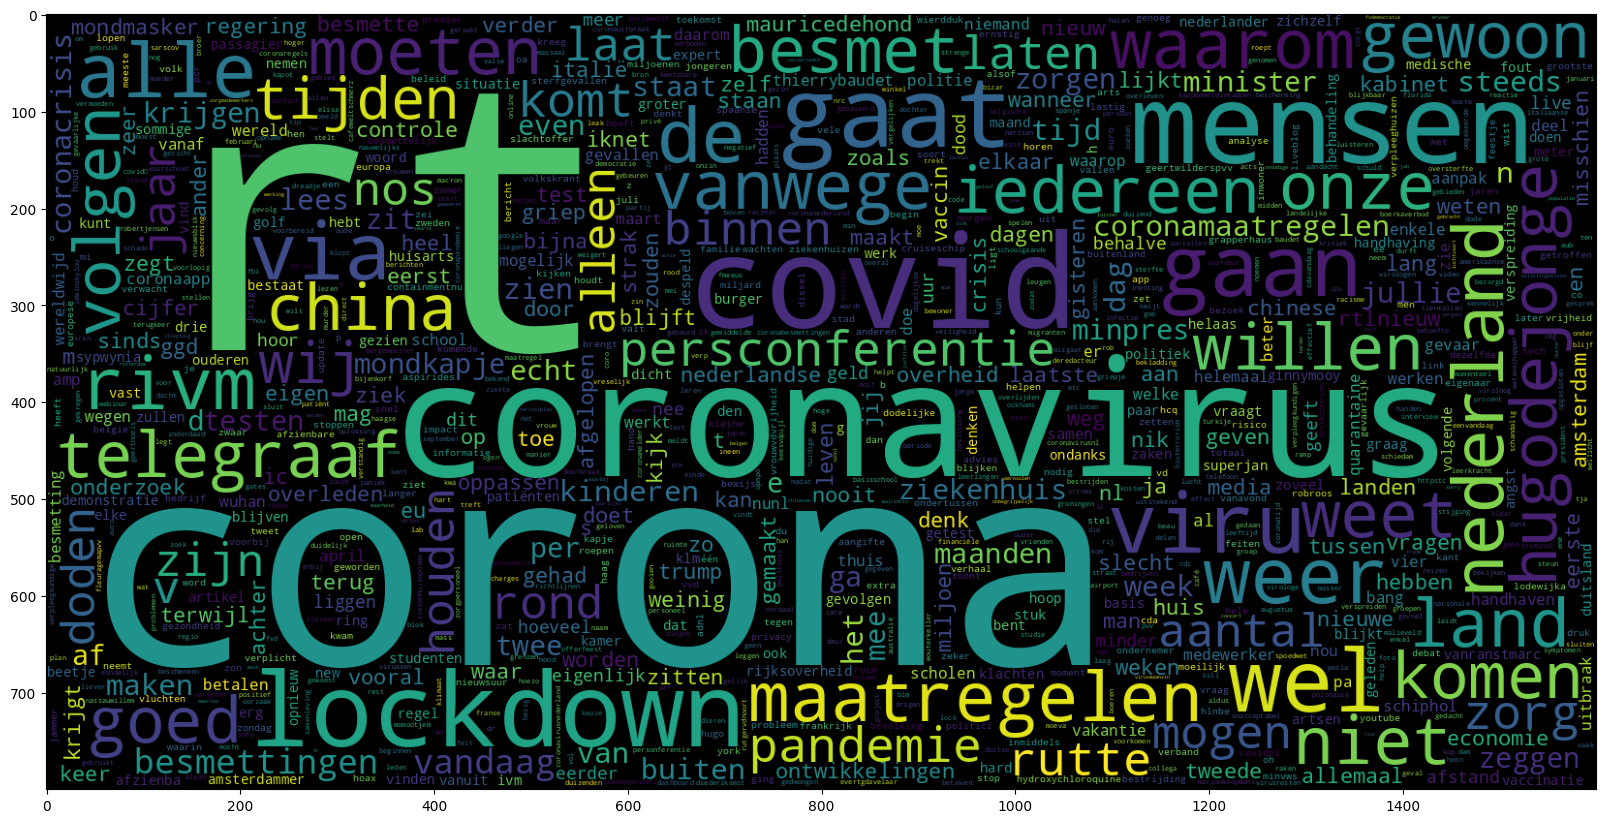

In [24]:
# Neg word cloud (attention: this uses the raw text data!)
# data_neg = data_neg[:9230]
plt.figure(figsize = (20,20))
wc_neg = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_neg['text'])))
plt.imshow(wc_neg)


### Word cloud for positive words

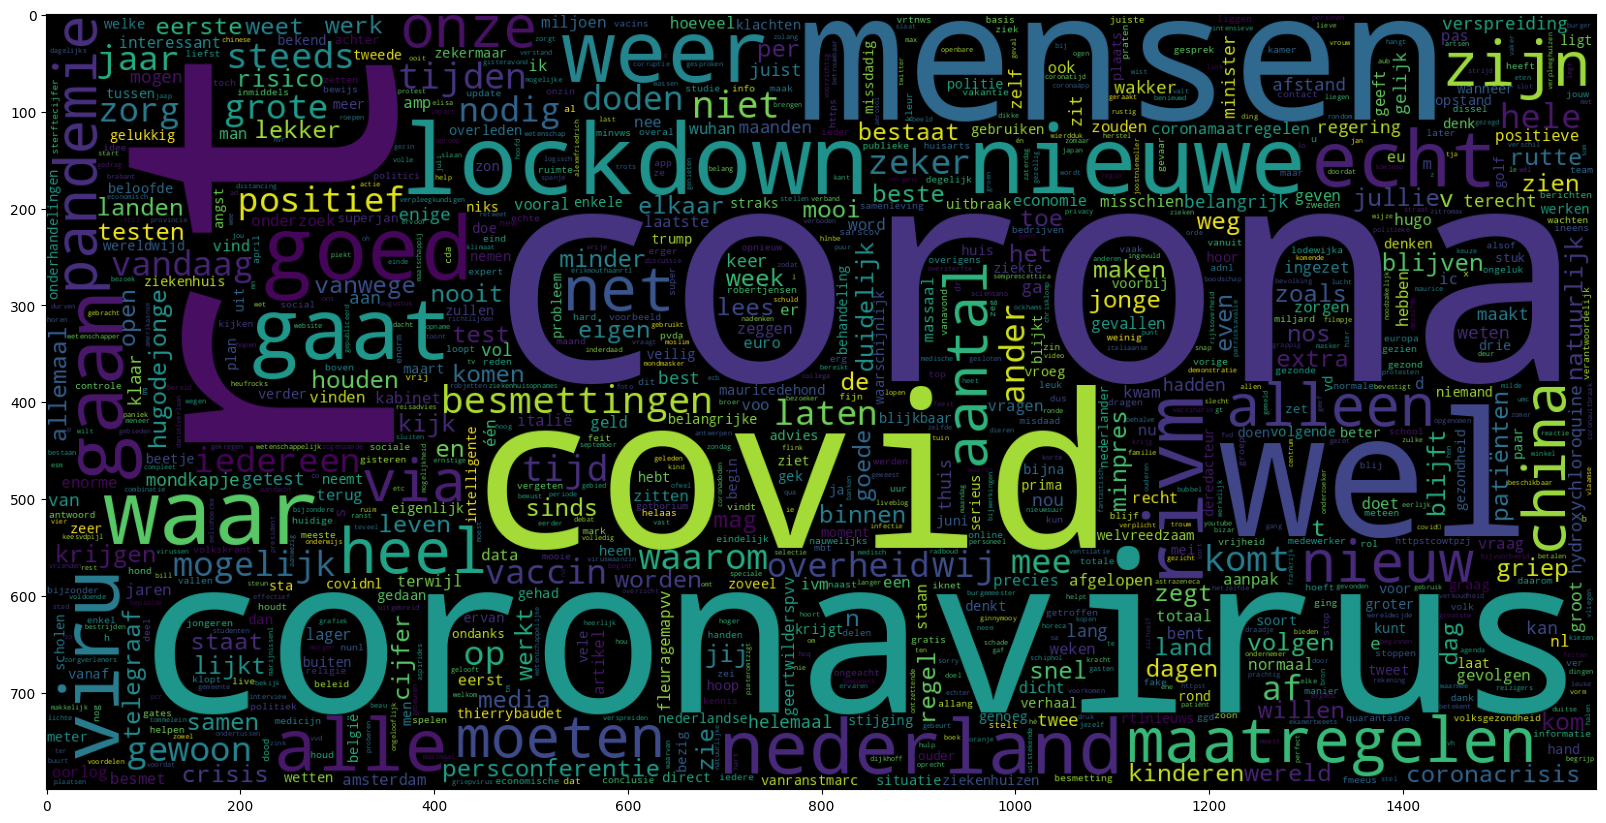

In [25]:
# pos wordcloud (attention: this uses the raw text data!)
# data_pos = data_pos[:17789]
plt.figure(figsize = (20,20))
wc_pos = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_pos['text'])))
plt.imshow(wc_pos)


## Modelling

## Prepare the data

In [26]:
# create the 'X' with the features, and create the'y' with the annotations/sentiment
X = data_preprocessed['text']
y = data_preprocessed['label']

In [27]:
# Split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [28]:
# Turn data into strings (ensures, otherwise may throw an error)
X_train = X_train.astype(str)
X_test = X_test.astype(str)

### Fit the TF-IDF Vectorizer

In [29]:
# Fit the tf-idf vectorizer on the training data (!)
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features = 500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [30]:
# Check how many feature words are extracted
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  99395


### Transform the data according to TF-IDF vectorizer

In [31]:
# Transform the data (both train and test data!) using the tf-idf vectorizer
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

## Extra: Topic modelling via Latent Dirichlet Allocation (LDA)


In [32]:
from sklearn.decomposition import LatentDirichletAllocation
num_components = 5
model_LDA = LatentDirichletAllocation(n_components = num_components)
lda_matrix = model_LDA.fit_transform(X_train)
lda_components = model_LDA.components_

In [33]:
terms = vectoriser.get_feature_names_out()
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['rt', 'corona', 'coronavirus', 'weten', 'we']
Topic 1:  ['rt', 'corona', 'we', 'coronavirus', 'over']
Topic 2:  ['rt', 'corona', 'coronavirus', 'over', 'gaan']
Topic 3:  ['rt', 'corona', 'we', 'coronavirus', 'gaan']
Topic 4:  ['rt', 'corona', 'coronavirus', 'we', 'gaan']


In [34]:
# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda_components, axis=1)[:, ::-1]
feature_names = np.array(vectoriser.get_feature_names_out())
mglearn.tools.print_topics(topics=range(5), feature_names = feature_names,
                           sorting = sorting, topics_per_chunk=5, n_words = 10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
rt            rt            rt            rt            rt            
corona        corona        corona        corona        corona        
coronavirus   we            coronavirus   we            coronavirus   
weten         coronavirus   over          coronavirus   we            
we            over          gaan          gaan          gaan          
covid         covid         covid         over          covid         
zijn          mens          we            lockdown      goed          
lockdown      willen        mens          mens          gaan goed     
over          wel           dag           covid         over          
de            lockdown      zijn          komen         oppass        




### Model Evaluation

In [35]:
# Define a function for model evaluation
# creds to https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Model 1: Train and evaluate a Linear Support Vector Classification model

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       357
         1.0       0.92      0.90      0.91       230

    accuracy                           0.93       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.93      0.93      0.93       587



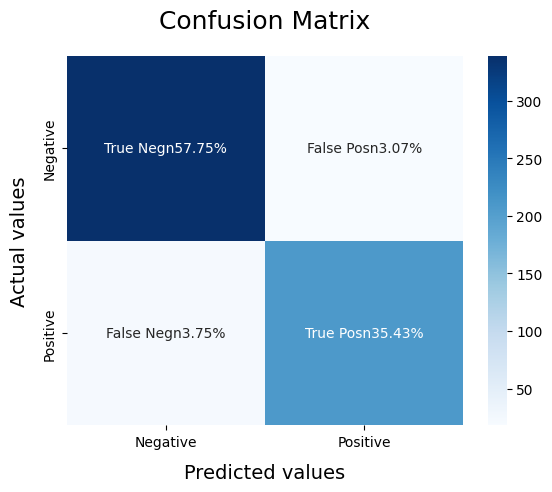

In [36]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred_svc = SVCmodel.predict(X_test)

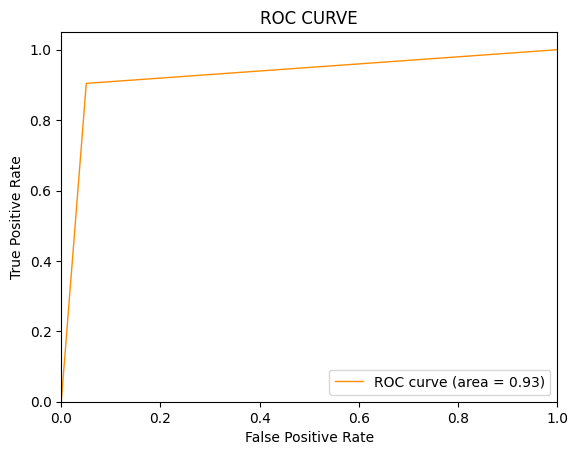

In [37]:
# Define a function for receiving a ROC curve and RUN it.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Model 2: Train and evaluate a Logistic regression model

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       357
         1.0       0.92      0.90      0.91       230

    accuracy                           0.93       587
   macro avg       0.93      0.92      0.92       587
weighted avg       0.93      0.93      0.93       587



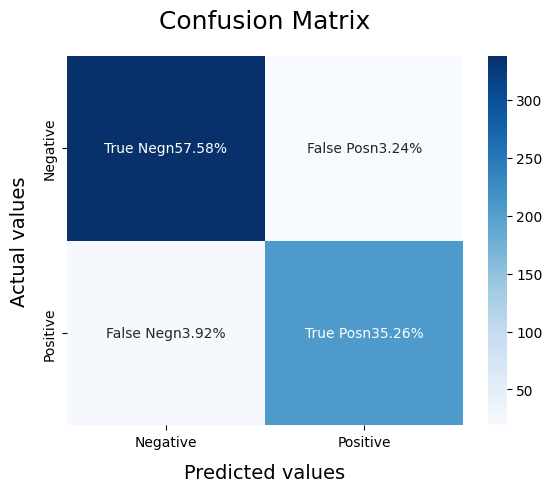

In [38]:
from sklearn.linear_model import LogisticRegressionCV

#LRmodel = LogisticRegression(max_iter = 1000, n_jobs=-1)
LRmodel = LogisticRegressionCV(max_iter = 1000, n_jobs=-1, cv = 5)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred_lr = LRmodel.predict(X_test)
# using the held-out sample, we achieved .91 accuracy

In [39]:
LRmodel.Cs # The function here: LogisticRegressionCV, already does grid search for us.
# and it found C=10 gives the best out of sample accuracy

10

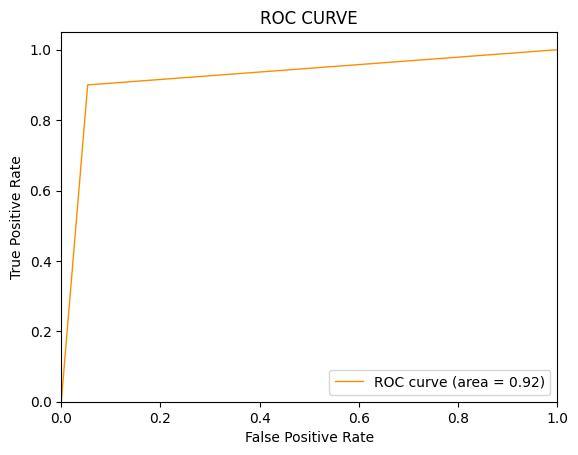

In [40]:
# Define a function for receiving a ROC curve and RUN it.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Cross validation and Grid Search for LR



In [41]:
# the LogisticCV already does that for us (i.e., the GridSearch) however, it might be nice to see how to do it in another way.
param_grid = [0.0001, 0.001, 0.01, 1, 10]
LRmodel_grid = LogisticRegressionCV(max_iter = 1000, cv =5, Cs=param_grid)
LRmodel_grid.fit(X_train, y_train)
round(LRmodel_grid.score(X_test, y_test), 2) # the model results with 0.91 prediction accuracy using the held out sample, no improvement

0.93

In [42]:
# the best C parameter found via grid search is 10
LRmodel_grid.C_

array([10.])

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       357
         1.0       0.93      0.90      0.91       230

    accuracy                           0.93       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.93      0.93      0.93       587



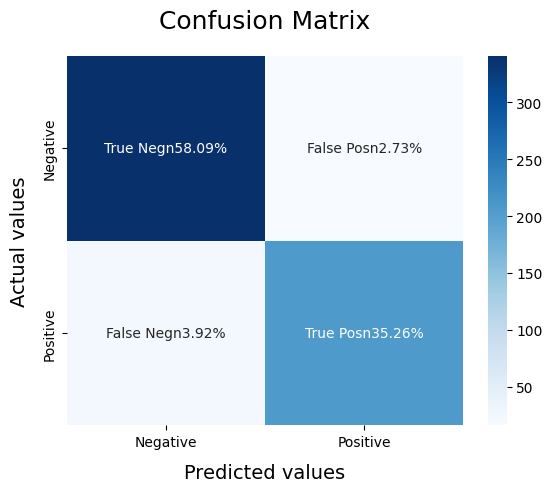

In [43]:
# model evaluation gives the same visualization, too.
model_Evaluate(LRmodel_grid)

In [44]:
# Here is yet another snippet:
# THIS SNIPPET WAS MORE APPLICABLE FOR OTHER ALGORITHMS TOO AND NOT ONLY TO LOGISTIC REG E.G., svc ETC(I.E. VERSATILE) it gives the same results as the above version
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(LogisticRegression(), X_train, y_train, cv = 5)
# round(scores.mean(), 2)

# param_grid = {"C":[0.0001, 0.001, 0.01, 1, 10]}
# GridSearchCV(LogisticRegression(max_iter=1000), cv = 5, param_grid = param_grid)
# grid.fit (X_train, y_train)
# grid.best_params_ # C:10 performs the best
# to get a nice visualization of the best LR model, we estimate an LR model with the best C paramter, C = 10, what we have found above
# LRmodel_C10 = LogisticRegressionCV(C = 10, cv = 5, max_iter = 1000, n_jobs=-1)
# LRmodel_C10.fit(X_train, y_train)
# model_Evaluate(LRmodel_C10)
# y_pred_lr_C10 = LRmodel_C10.predict(X_test)

<Axes: ylabel='term'>

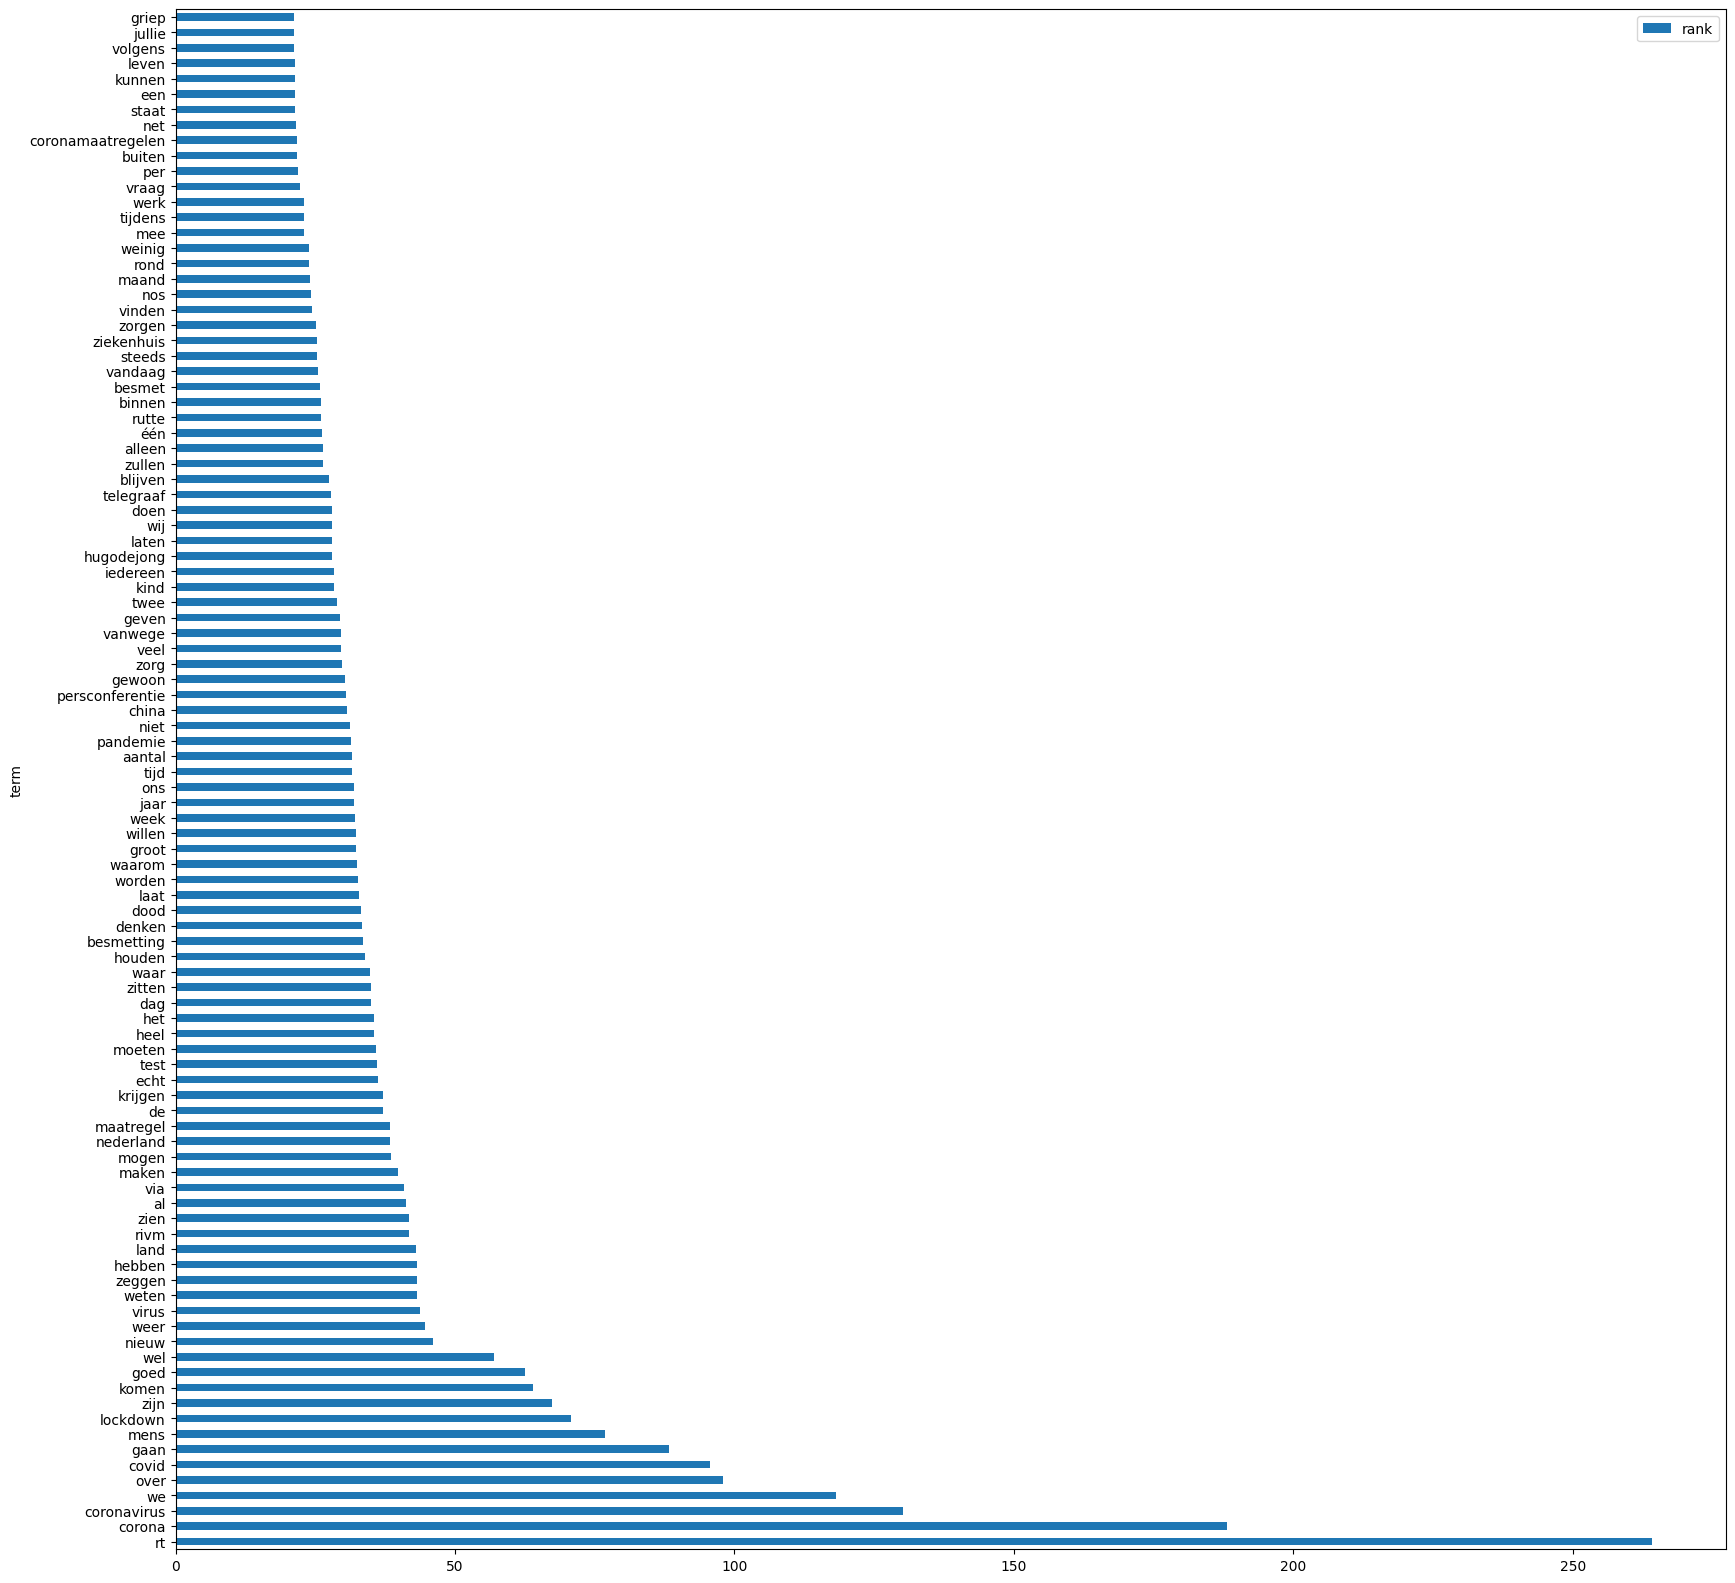

In [126]:
# Let's see which words were the most frequent according to tf-idf vectorization

sums = X_train.sum(axis=0)
terms = vectoriser.get_feature_names_out()

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
# Plotting
ranking = ranking.sort_values('rank', ascending=False)
ranking = ranking.iloc[0:100]
ranking.plot(x='term', y='rank', kind ='barh', figsize=(20, 20))

<Axes: ylabel='term/feature'>

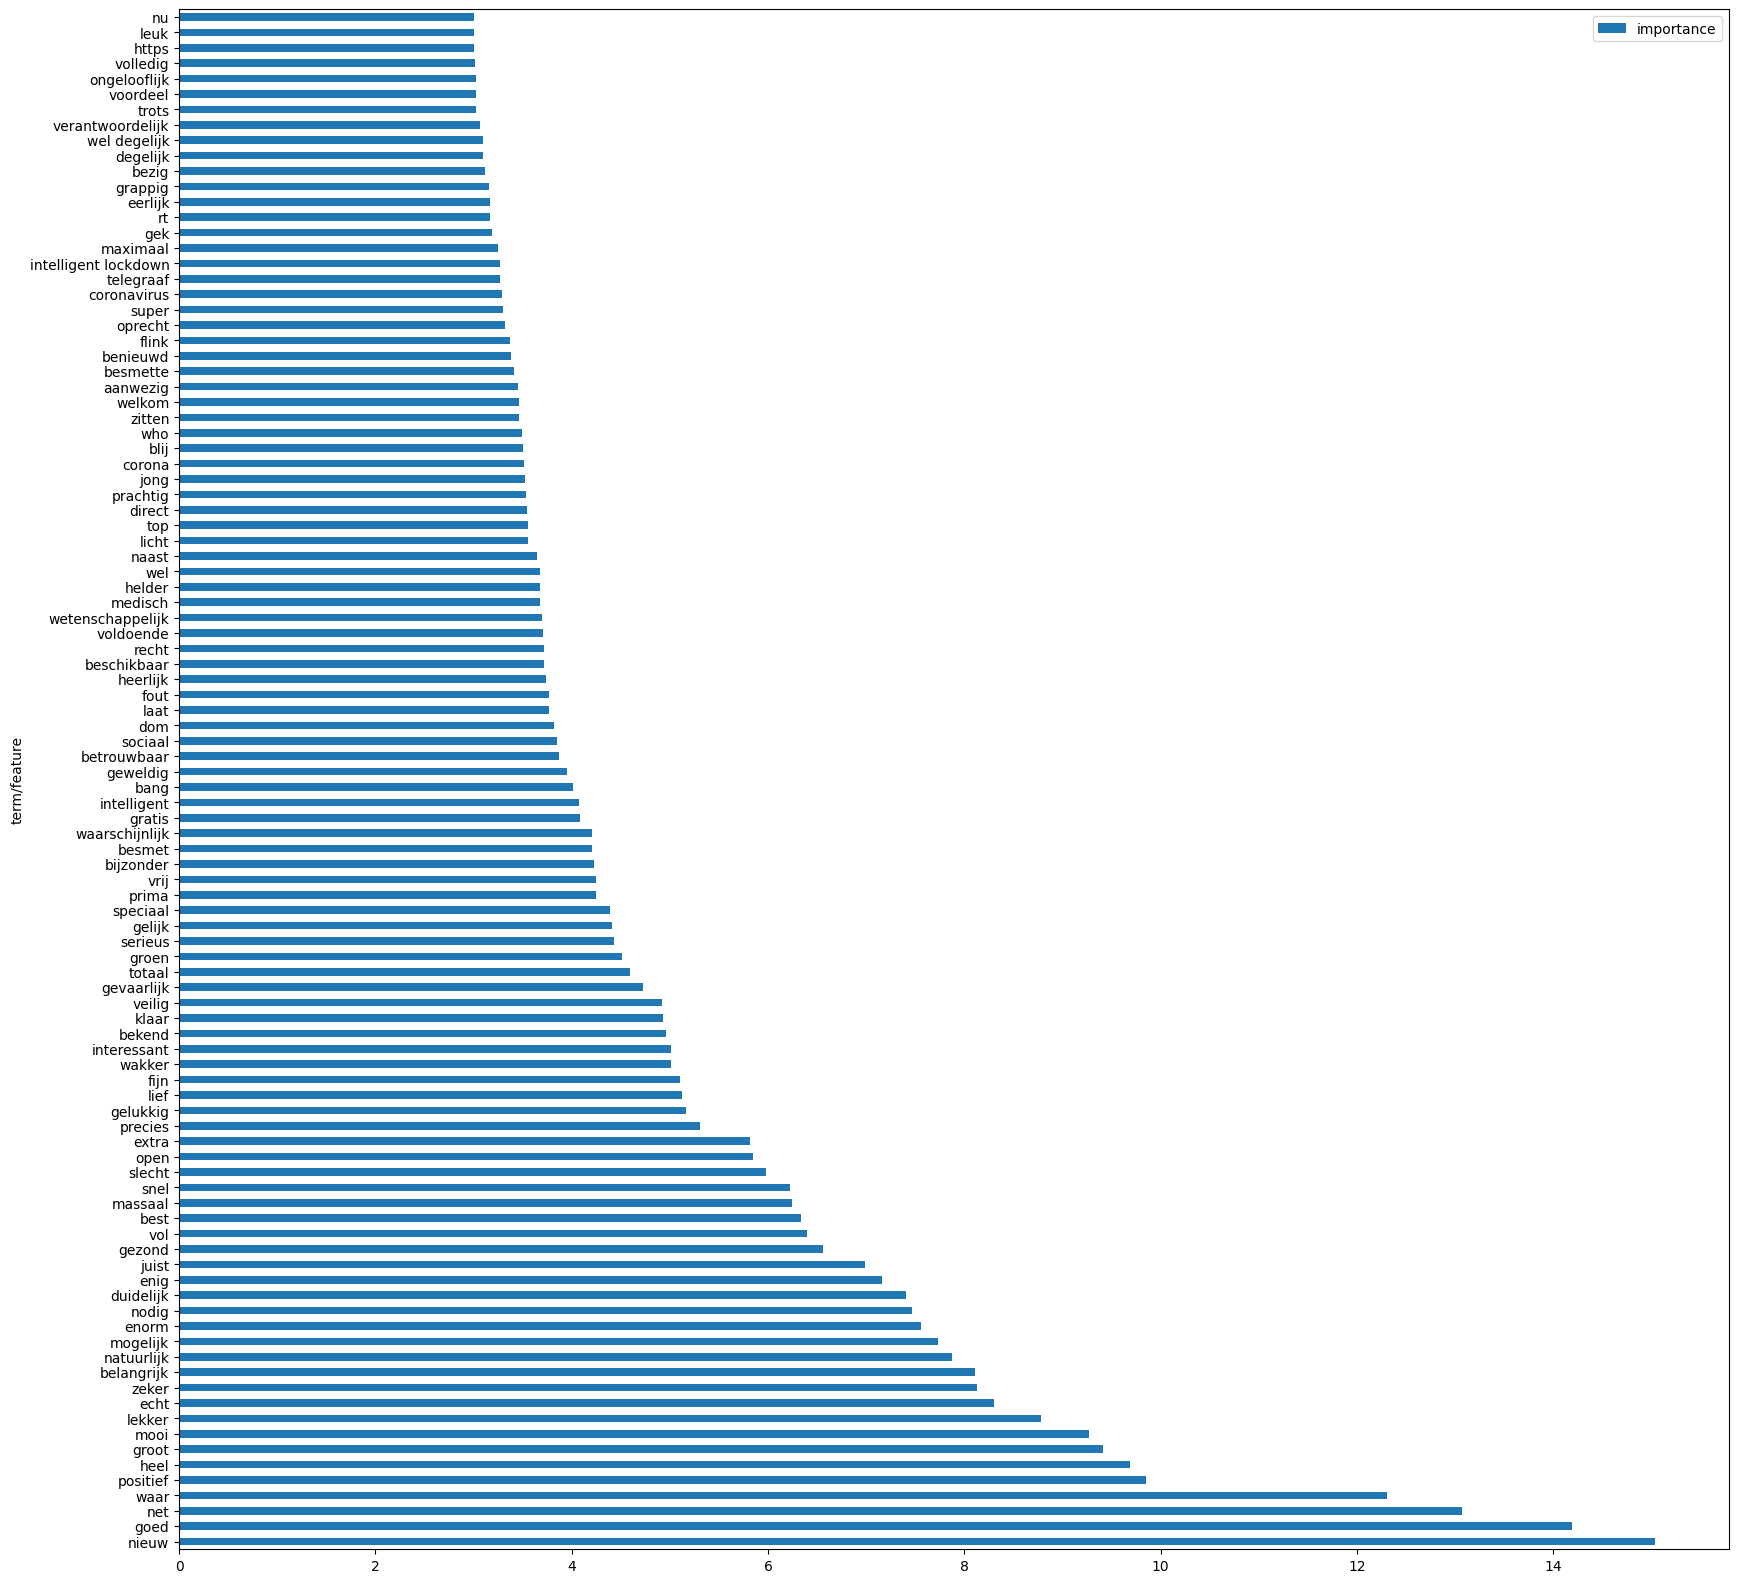

In [127]:
# Let's now see which terms from the tf-idf vectorizer had the highest coefficients/importance in our logistic regression model

coefficients = LRmodel_grid.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)
avg_importance_matrix = np.asmatrix(avg_importance)
terms = vectoriser.get_feature_names_out() # identical features, as extracted in the tf-idf vectorization


# connecting term to its coefficient magnitude in the model
dataLR = []
for col, term in enumerate(terms):
    dataLR.append( (term, avg_importance_matrix[0,col] ))

rankingLR = pd.DataFrame(dataLR, columns=['term/feature','importance'])

# Plotting
rankingLR = rankingLR.sort_values('importance', ascending=False)
rankingLR = rankingLR.iloc[0:100]
rankingLR.plot(x='term/feature', y= 'importance', kind= 'barh', figsize=(20,20))